# Monte Carlo Stock Simulations

**Simulating Stock Prices with Monte Carlo Methods**

Monte Carlo methods are a methodology by which we create a given model of an event, generate a series of random values from that model, and apply those values as inputs to a scenario many times in order to simulate what would happen over a long period of time. This allows us to make reasonable models of events whose probability distribution is inherently non-deterministic or at least very difficult to model with analytical methods.

The four overarching steps to conducting a Monte Carlo analysis are:
1. Construct a Model
2. Generate Random Values
3. Apply them over many, many trials
4. Collect results and analyze.


**Construct a Model**

To model a stock price, we will simply assume that the change in price of the stock will follow a normal distribution with a mean and standard deviation (which, in finance, are called drift and shock respectively).

![alt text](https://bit.ly/2RQdOjb)

In this image:
1. µ is the expected price change (or expected level of return)
2. σ is the volatility of the stock
3. ∆t is the change in time
4. ε is a random scalar to modify the volatility
5. S is the stock price

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# authenticate
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Import required libraries
import math
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data

In [0]:
# grab the financial data for Apple from Yahoo starting at January 1, 2000
apple = data.DataReader('AAPL', 'yahoo',start='1/1/2000')

In [0]:
# we calculate the number of days that have elapsed for every price point
time_elapsed = (apple.index[-1] - apple.index[0]).days

In [0]:
# compute the compounded annual growth rate (cagr)
price_ratio = (apple['Adj Close'][-1] / apple['Adj Close'][1])
inverse_number_of_years = 365.0 / time_elapsed
cagr = price_ratio ** inverse_number_of_years - 1

**Volatility** is the standard deviation of the percent changes in price for each day. This makes sense since it is a measure of how sporadically the price of the stock is changing.

In [0]:
# determine the annual volatility of returns
vol = apple['Adj Close'].pct_change().std()

In [0]:
# to make this figure useful as an annual measure, it has to be scaled by an annualization factor
number_of_trading_days = 252
vol = vol * math.sqrt(number_of_trading_days)

In [9]:
print ("cagr (mean returns) : ", str(round(cagr,4)))
print ("vol (standard deviation of return : )", str(round(vol,4)))

cagr (mean returns) :  0.2514
vol (standard deviation of return : ) 0.4034


-------------------------------------------------------------------------


**Generate Random Values**

Creating a random sample using the above parameters utilising the normal function from the numpy library.

In [0]:
daily_return_percentages = np.random.normal(cagr/number_of_trading_days, vol/math.sqrt(number_of_trading_days),number_of_trading_days)+1

In [0]:
# creating a price series from this list of percentages, starting with the most recent price
# to generate each consecutive price, we will apply the price change to the most recent price resulting in a distribution called a "random walk"

price_series = [apple['Adj Close'][-1]]

for drp in daily_return_percentages:
    price_series.append(price_series[-1] * drp)

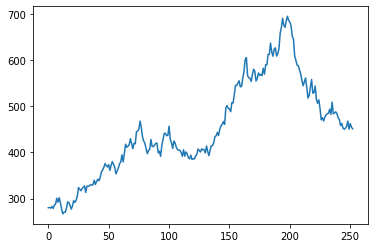

In [12]:
plt.plot(price_series)
plt.show()

The above graphical representation shows a single simulation of a potential future price series that was based on the normal distribution of daily returns we calculated earlier.

Running this type of simulation multitude of times can help us gain the true insight.

--------------------------------------------------------------------------------



**Apply the simulations over many, many trials**


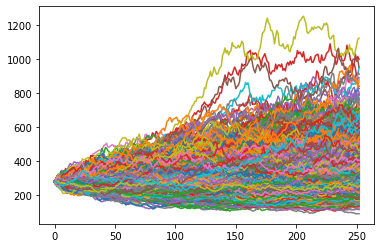

In [13]:
number_of_trials = 1000
for i in range(number_of_trials):
    daily_return_percentages = np.random.normal(cagr/number_of_trading_days, vol/math.sqrt(number_of_trading_days),number_of_trading_days)+1
    price_series = [apple['Adj Close'][-1]]

    for drp in daily_return_percentages:
        price_series.append(price_series[-1] * drp)
    
    plt.plot(price_series)
plt.show()

The above graphical representation shows what a thousand different possible price series look like.

Now constructing a histogram of the ending price points to see a distribution of where our "random" predictions "end up" and make meaningful interpretations from it.

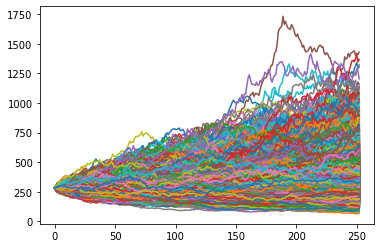

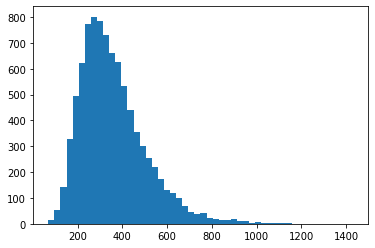

In [14]:
ending_price_points = []
larger_number_of_trials = 9001 # It's over 9000
for i in range(larger_number_of_trials):
    daily_return_percentages = np.random.normal(cagr/number_of_trading_days, vol/math.sqrt(number_of_trading_days),number_of_trading_days)+1
    price_series = [apple['Adj Close'][-1]]

    for drp in daily_return_percentages:
        price_series.append(price_series[-1] * drp)
    
    plt.plot(price_series)
    
    ending_price_points.append(price_series[-1])

plt.show()

plt.hist(ending_price_points,bins=50)
plt.show()

--------------------------------------------------------------------------------

**Collect Results and Analyze**

The following is done to get the mean of this distribution in order to get an expected value of our ending price points.

In [15]:
expected_ending_price_point = round(np.mean(ending_price_points),2)
print("Expected Ending Price Point : ", str(expected_ending_price_point))

Expected Ending Price Point :  359.12


Now, due to the Law of Large Numbers, this number (which you can think of as the sample mean) will eventually converge to the last, known price point multiplied by the expected daily price change (the population mean).

In [16]:
population_mean = (cagr+1) * apple['Adj Close'][-1]
print ("Sample Mean : ", str(expected_ending_price_point))
print ("Population Mean: ", str(round(population_mean,2)));
print ("Percent Difference : ", str(round((population_mean - expected_ending_price_point)/population_mean * 100,2)), "%")

Sample Mean :  359.12
Population Mean:  350.9
Percent Difference :  -2.34 %


The true usefulness of Monte Carlo simulations, though, is to see the distribution of ending price points and guage risk vs. reward. 

Taking the top 10 and bottom 10 percentiles we have:

In [17]:
top_ten = np.percentile(ending_price_points,100-10)
bottom_ten = np.percentile(ending_price_points,10);
print ("Top 10% : ", str(round(top_ten,2)))
print ("Bottom 10% : ", str(round(bottom_ten,2)))

Top 10% :  553.08
Bottom 10% :  198.68


From this, we can deduce that there is a 10% chance that the stock will grow to USD 553.08 and an equal chance that it will drop to USD 198.68.

Now, we can ask the question, "is it worth it to risk the 10% chance that the stock will drop to USD 198.68 if my expected reward is USD 359.12?"

In order to illustrate this situation, let us draw the top ten and bottom ten percentiles on the histogram as well as the last known price point.

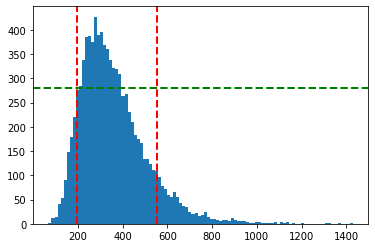

In [18]:
plt.hist(ending_price_points,bins=100)
plt.axvline(top_ten,color='r',linestyle='dashed',linewidth=2)
plt.axvline(bottom_ten,color='r',linestyle='dashed',linewidth=2)
plt.axhline(apple['Adj Close'][-1],color='g', linestyle='dashed',linewidth=2)
plt.show()

Thus it can be concluded that there seems like a lot more to gain than there is to lose.

Here we've constructed a model for a stock's daily returns. Then, we generated random values from that model. Next, we applied those values to an equation representing change over time. Lastly, we collected the data and made careful observations and risk vs. reward assessments keeping in mind the limitations of the Monte Carlo simulation.

Probabilistically, the Monte Carlo methodology offers the advantage of being a very simple and straightfoward algorithm for predicting the extrema of a given situation with reasonable confidance thanks to the Law of Large Numbers.